##Retriving Data

In [ ]:
! unzip "/content/drive/MyDrive/Brain_Tumor_Classification/archive.zip"

Archive:  /content/drive/MyDrive/Brain_Tumor_Classification/archive.zip
replace Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

##Library

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import json
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax, RMSprop
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##Handling Data

In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [ ]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
tr_df = train_df('/content/Training')

In [ ]:
tr_df

,Class Path,Class
0,/content/Training/meningioma/Tr-me_0076.jpg,meningioma
1,/content/Training/meningioma/Tr-me_1306.jpg,meningioma
2,/content/Training/meningioma/Tr-me_0845.jpg,meningioma
3,/content/Training/meningioma/Tr-me_0174.jpg,meningioma
4,/content/Training/meningioma/Tr-me_0876.jpg,meningioma
...,...,...
5707,/content/Training/pituitary/Tr-pi_0912.jpg,pituitary
5708,/content/Training/pituitary/Tr-pi_0030.jpg,pituitary
5709,/content/Training/pituitary/Tr-pi_1195.jpg,pituitary
5710,/content/Training/pituitary/Tr-pi_1390.jpg,pituitary


In [ ]:
ts_df = test_df('/content/Testing')

In [ ]:
ts_df

,Class Path,Class
0,/content/Testing/meningioma/Te-me_0051.jpg,meningioma
1,/content/Testing/meningioma/Te-me_0129.jpg,meningioma
2,/content/Testing/meningioma/Te-me_0207.jpg,meningioma
3,/content/Testing/meningioma/Te-me_0156.jpg,meningioma
4,/content/Testing/meningioma/Te-me_0143.jpg,meningioma
...,...,...
1306,/content/Testing/pituitary/Te-pi_0109.jpg,pituitary
1307,/content/Testing/pituitary/Te-pi_0260.jpg,pituitary
1308,/content/Testing/pituitary/Te-pi_0119.jpg,pituitary
1309,/content/Testing/pituitary/Te-pi_0086.jpg,pituitary


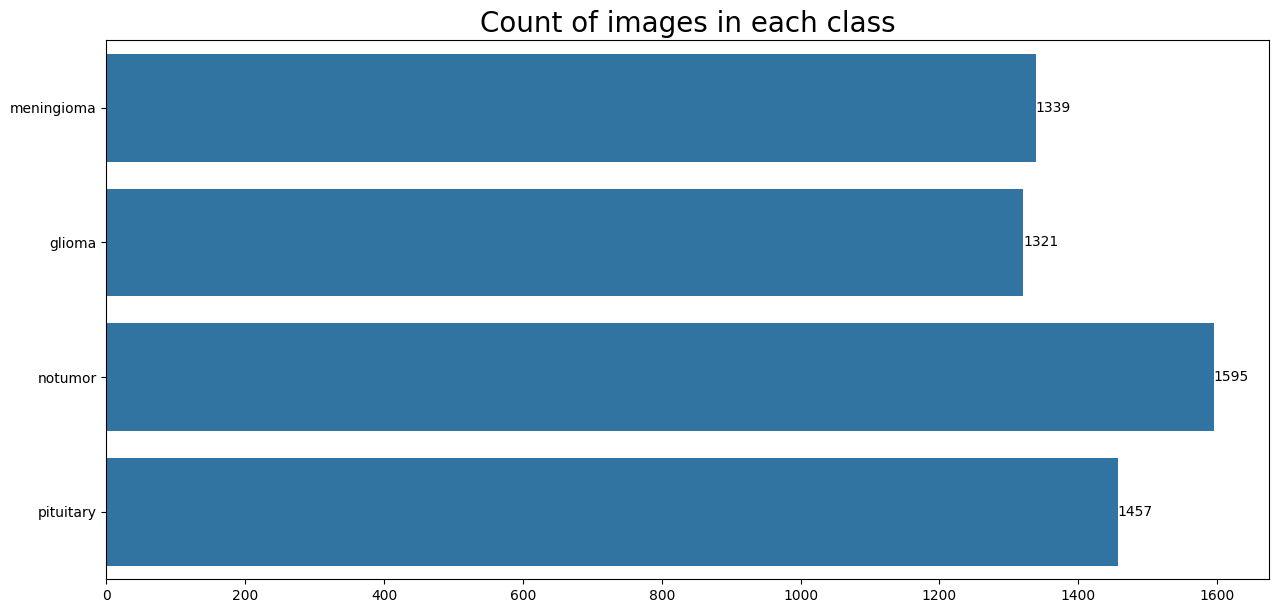

In [ ]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()


<ipython-input-9-e20632a11d41>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=ts_df['Class'], palette='viridis')


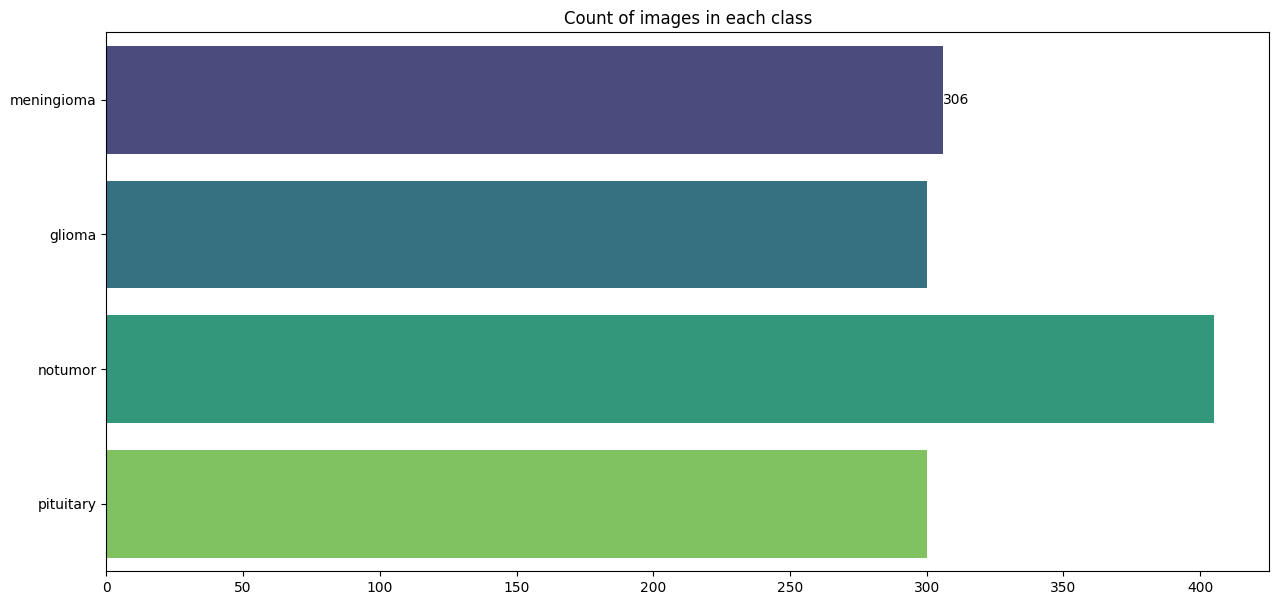

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

In [ ]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.7, random_state=20, stratify=ts_df['Class'])

In [ ]:
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 394 entries, 1003 to 388
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Class Path  394 non-null    object
 1   Class       394 non-null    object
dtypes: object(2)
memory usage: 9.2+ KB


In [ ]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 917 validated image filenames belonging to 4 classes.
Found 394 validated image filenames belonging to 4 classes.


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


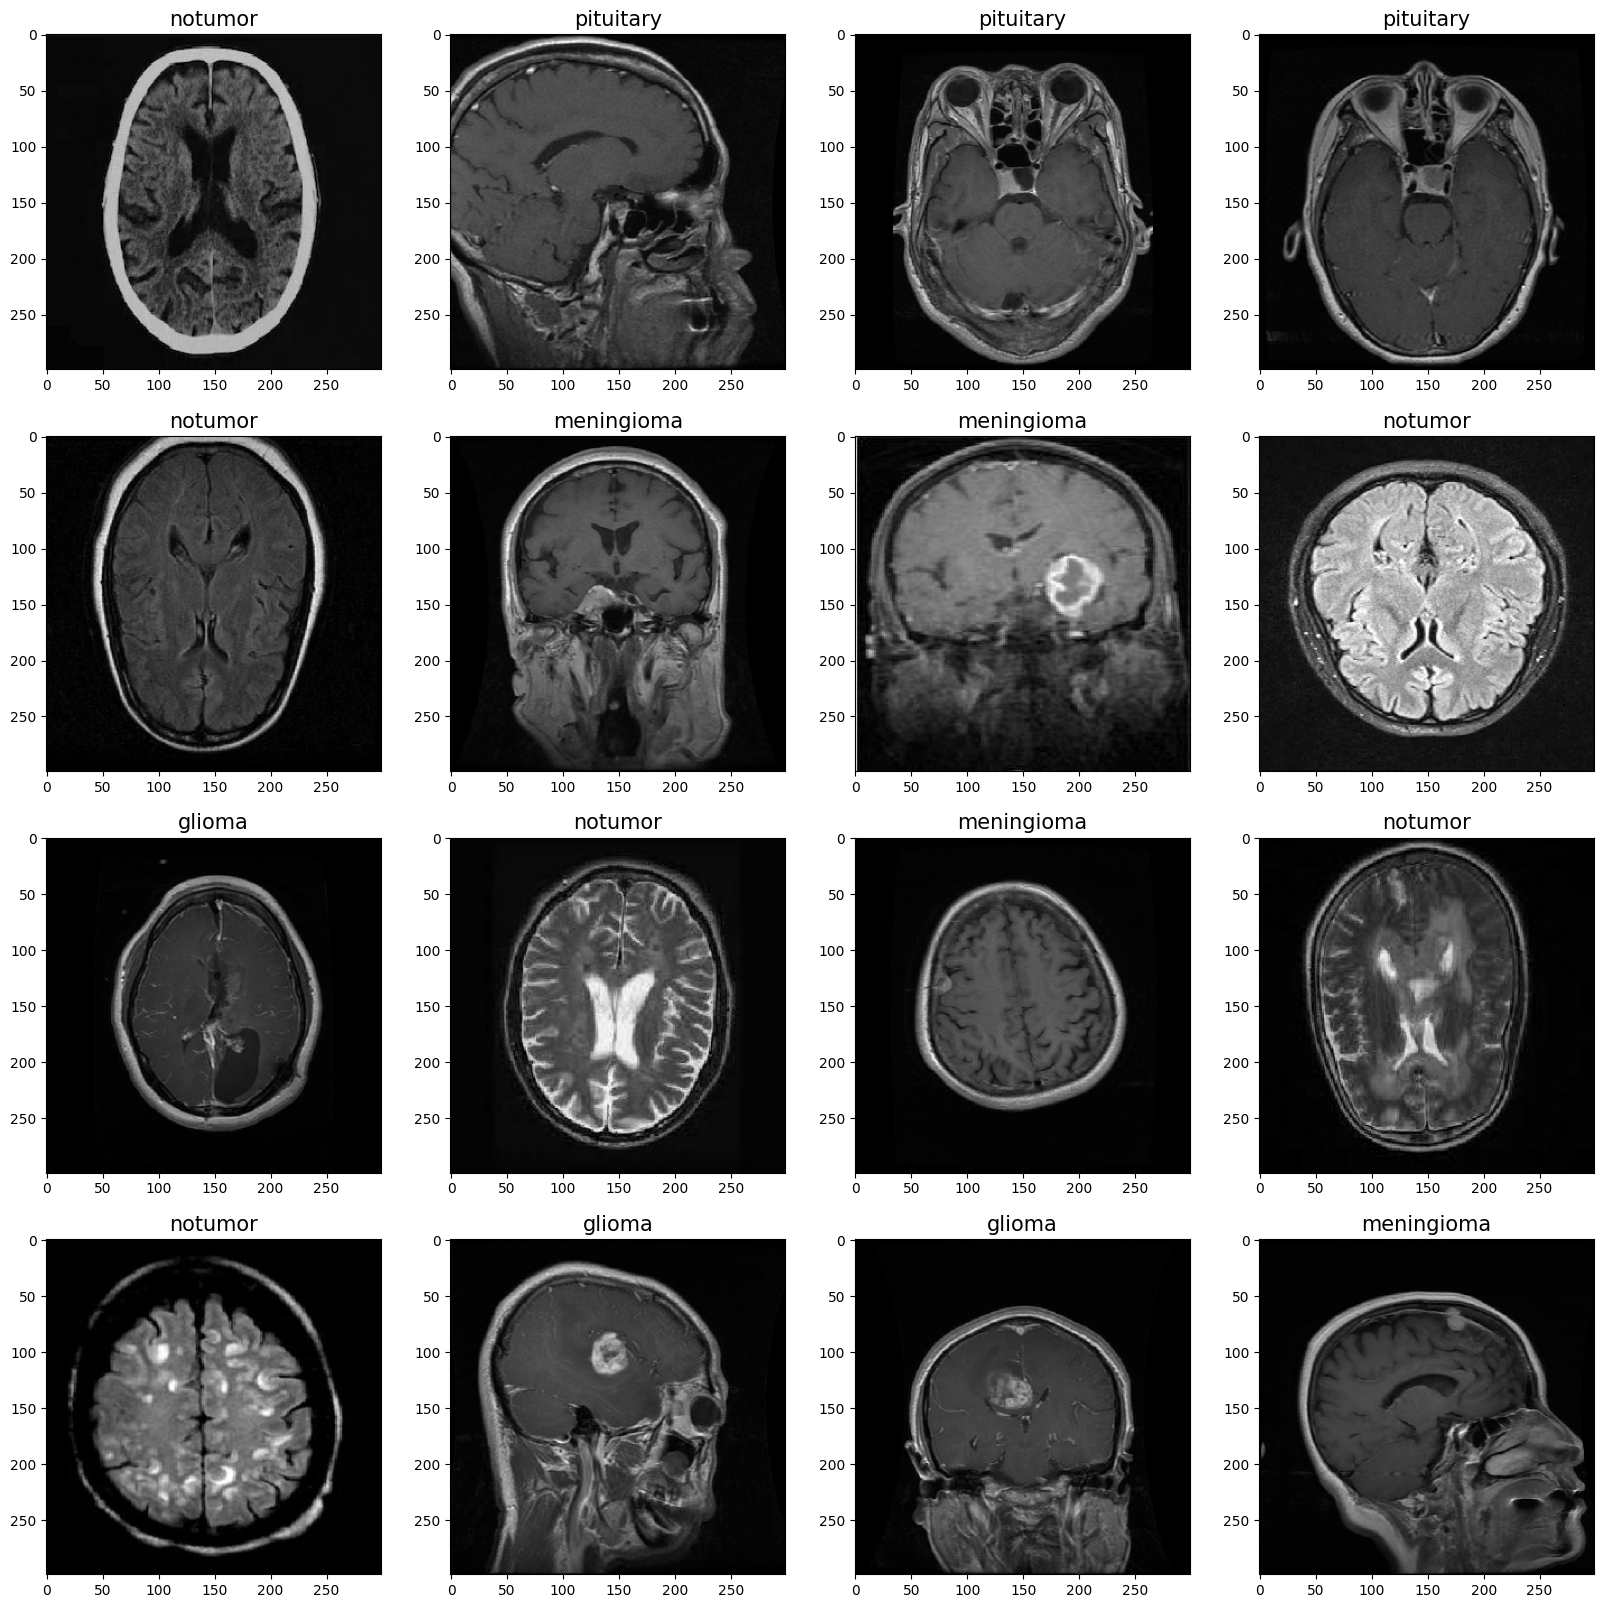

In [ ]:
class_dict = tr_gen.class_indices
print(class_dict)
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()


##Model


In [ ]:
img_shape=(299,299,3)

Resnet_model = tf.keras.applications.ResNet50(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

mobilenet_model = tf.keras.applications.MobileNetV2(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

EfficientNet_model = tf.keras.applications.EfficientNetB0(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

DenseNet_model = tf.keras.applications.DenseNet121(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max') #for medical images

Inception_model = tf.keras.applications.InceptionV3(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

VGG_model = tf.keras.applications.VGG16(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

Xception_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

base_models = [Resnet_model, mobilenet_model, EfficientNet_model, DenseNet_model, Inception_model, VGG_model, Xception_model]

def Model(base_model):
  for layer in base_model.layers:
    layer.trainable = False

  model = Sequential([
      base_model,
      Flatten(),
      Dropout(rate= 0.3),
      Dense(128, activation= 'relu'),
      Dropout(rate= 0.25),
      Dense(4, activation= 'softmax')
  ])

  model.compile(Adamax(learning_rate= 0.001),
                loss= 'categorical_crossentropy',
                metrics= ['accuracy',
                          Precision(),
                          Recall()])

  model.summary()
  return model


In [ ]:
def plot_model(model):
  tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# def model_training(base_models):
#   histories = []
#   for base_model in base_models:
#     print('now working on {}'.format(base_model.__class__.__name__))
#     model = Model(base_model)
#     plot_model(model)
#     history = model.fit(tr_gen,
#                         epochs=10,
#                         validation_data=valid_gen,
#                         shuffle= False)
#     histories.append(history)
#     with open('/content/drive/MyDrive/Brain_Tumor_Classification/{}.pkl'.format(base_model.__class__.__name__), 'wb') as file:
#       pickle.dump(model, file)
#   return histories

##Model Fitting

In [ ]:
def model_fit(model,model_name):
  hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)
  with open('/content/drive/MyDrive/Brain_Tumor_Classification/{}.pkl'.format(model_name), 'wb') as file:
    pickle.dump(model, file)
  return hist


In [ ]:
model = Model(Xception_model)
plot_model(model)
history = model_fit(model, 'Xception_model')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21124268 (80.58 MB)
Trainable params: 2627

In [ ]:
import json
with open('/content/drive/MyDrive/Brain_Tumor_Classification/mobilenet_history.json', 'w') as file:
  json.dump(history.history, file)

In [ ]:
def loading_file(url):
  with open(url, 'r') as f:
    hist = json.load(f)
    return hist

In [ ]:
desnet = loading_file('/content/drive/MyDrive/Brain_Tumor_Classification/DenseNet_history.json')
efficientNet = loading_file('/content/drive/MyDrive/Brain_Tumor_Classification/EfficientNet_history.json')
inception = loading_file('/content/drive/MyDrive/Brain_Tumor_Classification/Inception_history.json')
mobilenet = loading_file('/content/drive/MyDrive/Brain_Tumor_Classification/Mobilenet_history.json')
resnet = loading_file('/content/drive/MyDrive/Brain_Tumor_Classification/Resnet_history.json')
vgg = loading_file('/content/drive/MyDrive/Brain_Tumor_Classification/VGG_history.json')
xception = loading_file('/content/drive/MyDrive/Brain_Tumor_Classification/Xception_history.json')

In [ ]:
print(history.history)
hist = history

{'loss': [1.2947301864624023, 0.696127712726593, 0.5842283964157104, 0.5277256965637207, 0.4858311116695404, 0.46528613567352295, 0.43345239758491516, 0.4102686643600464, 0.3928109109401703, 0.37892651557922363], 'accuracy': [0.6015406250953674, 0.7184873819351196, 0.769432783126831, 0.7981442809104919, 0.8114495873451233, 0.8254551887512207, 0.8333333134651184, 0.8427870869636536, 0.8522409200668335, 0.8578431606292725], 'precision_3': [0.6501909494400024, 0.7740679979324341, 0.8132150173187256, 0.8292543888092041, 0.8396831154823303, 0.8520888090133667, 0.8573021292686462, 0.8676580190658569, 0.8717523217201233, 0.874157726764679], 'recall_3': [0.5365896224975586, 0.6615896224975586, 0.7218137383460999, 0.7652310729026794, 0.779411792755127, 0.7927170991897583, 0.8077731132507324, 0.8172268867492676, 0.8282563090324402, 0.8403361439704895], 'val_loss': [0.6545785665512085, 0.6039437651634216, 0.5053688883781433, 0.434630423784256, 0.45028162002563477, 0.44516023993492126, 0.408047884

In [ ]:


# Save the model
# with open('/content/drive/MyDrive/Brain_Tumor_Classification/model.pkl', 'wb') as file:
#     pickle.dump(model, file)
# with open('/content/drive/MyDrive/Machine Learning/Real or Fake Project/model.pkl', 'rb') as file:
#     model = pickle.load(file)

In [ ]:
# histories = model_training(base_models)
# print(histories[1].history.keys())

now working on Functional
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 23850500 (90.9

KeyboardInterrupt: 

In [ ]:
import re

In [ ]:
def plotting(hist):
    pattern1 = r'^precision_(\d+)$'
    pattern2 = r'^recall_(\d+)$'
    pattern3 = r'^val_recall_(\d+)$'
    pattern4 = r'^val_precision_(\d+)$'
    for key in hist.keys():
        if re.match(pattern1, key):
            tr_per = hist[key]
        elif re.match(pattern2, key):
            tr_recall = hist[key]
        elif re.match(pattern3, key):
            val_recall = hist[key]
        elif re.match(pattern4, key):
            val_per = hist[key]

    v = hist.keys()
    tr_acc = hist['accuracy']
    tr_loss = hist['loss']

    val_acc = hist['val_accuracy']
    val_loss = hist['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_precision = np.argmax(val_per)
    per_highest = val_per[index_precision]
    index_recall = np.argmax(val_recall)
    recall_highest = val_recall[index_recall]

    Epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'Best epoch = {str(index_loss + 1)}'
    acc_label = f'Best epoch = {str(index_acc + 1)}'
    per_label = f'Best epoch = {str(index_precision + 1)}'
    recall_label = f'Best epoch = {str(index_recall + 1)}'


    plt.figure(figsize=(20, 12))
    plt.style.use('fivethirtyeight')


    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_per, 'r', label='Precision')
    plt.plot(Epochs, val_per, 'g', label='Validation Precision')
    plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
    plt.title('Precision and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_recall, 'r', label='Recall')
    plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
    plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
    plt.title('Recall and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)

    plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
    plt.show()


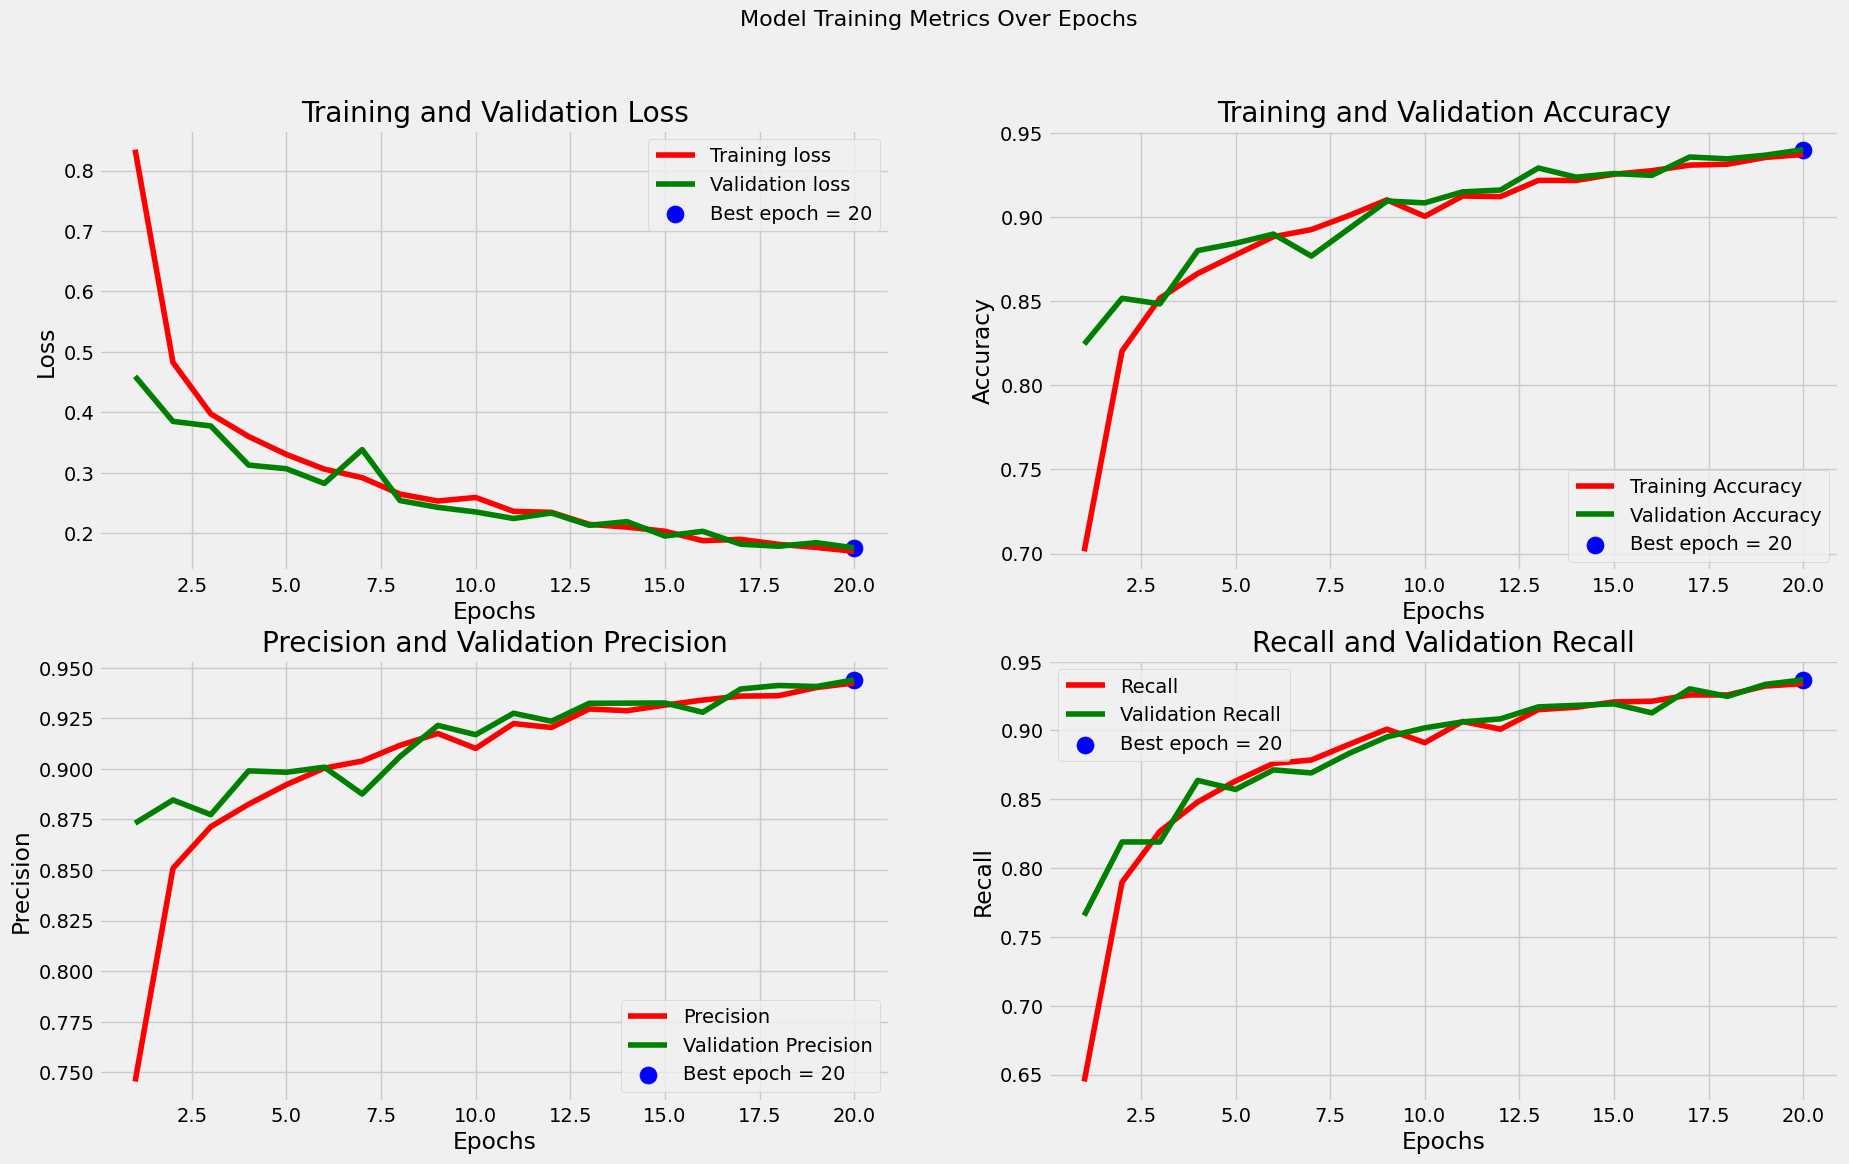

In [ ]:
plotting(xception)

In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

41/41 [==============================] - 5s 120ms/step - loss: 0.0168 - accuracy: 0.9954 - precision_1: 0.9954 - recall_1: 0.9954
Train Loss: 0.0021
Train Accuracy: 99.92%
--------------------
Validation Loss: 0.0638
Validation Accuracy: 98.08%
--------------------
Test Loss: 0.0168
Test Accuracy: 99.54%


In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 5s 115ms/step


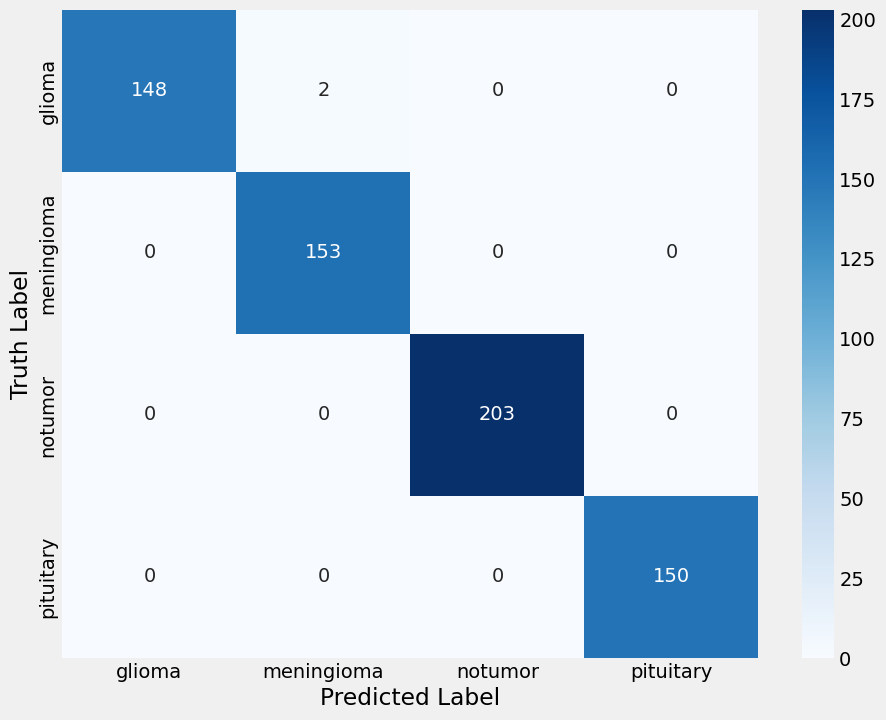

In [ ]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.99      0.99      0.99       153
           2       1.00      1.00      1.00       203
           3       1.00      1.00      1.00       150

    accuracy                           1.00       656
   macro avg       1.00      1.00      1.00       656
weighted avg       1.00      1.00      1.00       656



In [ ]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 [==============================] - 1s 1s/step


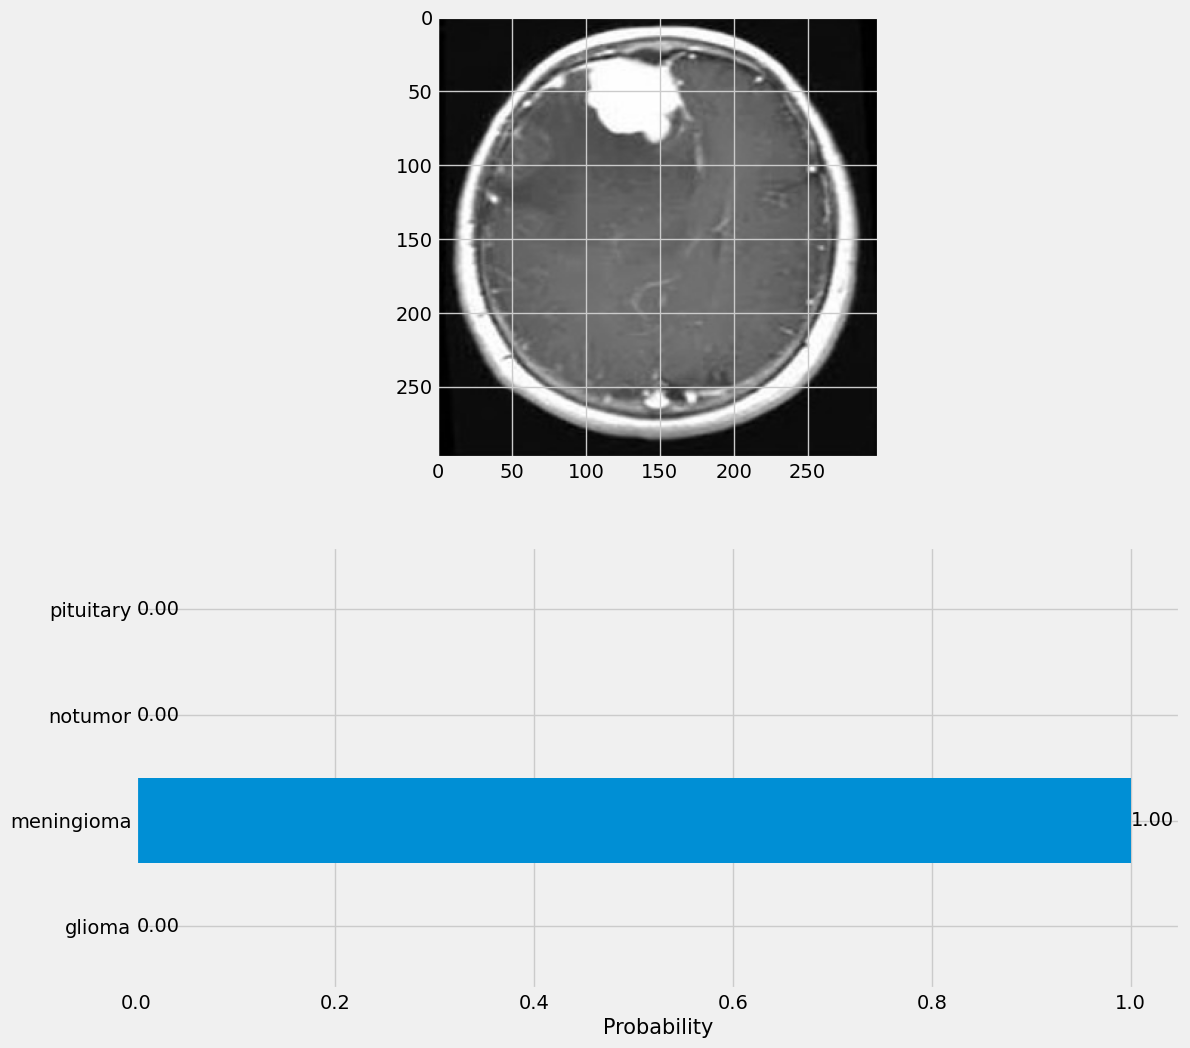

In [ ]:
predict('/content/Testing/meningioma/Te-meTr_0008.jpg')